In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

data = pd.read_csv('../chapter2/data/nyc_data.csv', parse_dates=['pickup_datetime','dropoff_datetime'])

In [3]:
pickup = data[['pickup_longitude', 'pickup_latitude']].values
dropoff = data[['dropoff_longitude', 'dropoff_latitude']].values
pickup

array([[-73.955925,  40.781887],
       [-74.005501,  40.745735],
       [-73.969955,  40.79977 ],
       ..., 
       [-73.993492,  40.729347],
       [-73.978477,  40.772945],
       [-73.987206,  40.750568]])

In [4]:
#배열선택1
print(pickup[3,1])

40.755081


In [5]:
#배열선택2
pickup[1:7:2, 1:]

array([[ 40.745735],
       [ 40.755081],
       [ 40.768978]])

In [7]:
#배열선택3
lon = pickup[:,0]
lon

array([-73.955925, -74.005501, -73.969955, ..., -73.993492, -73.978477,
       -73.987206])

In [13]:
lat = pickup[:,1]

In [14]:
#배열의 불린연산
lon_min, lon_max = (-73.98330, -73.98025)
lat_min, lat_max = (40.76724, 40.76871)

In [15]:
in_lon = (lon_min <= lon) & (lon <= lon_max) # &AND |OR
in_lon

array([False, False, False, ..., False, False, False], dtype=bool)

In [16]:
#얼마나 많은 True 가 있는가?
in_lon.sum() #True는 1, False 는 0 취급

69163

In [17]:
in_lat = (lat_min <= lat) & (lat <= lat_max)

In [18]:
in_lonlat = in_lon & in_lat
in_lonlat.sum()

3998

In [19]:
in_lonlat

array([False, False, False, ..., False, False, False], dtype=bool)

In [20]:
np.nonzero(in_lonlat)[0] #불린 배열에서 True에 해당하는 인덱스틑 반환

array([   901,   1011,   1066, ..., 845749, 845903, 846080])

In [21]:
#하차 죄표
# T는 행렬의 전치Transpose. 여기선, (N,2) => (2,N)
# lon1는 첫행, lat1은 두번째 행
lon1, lat1 = dropoff.T 

In [22]:
#모든 운행에서 두 위치간 직선거리
# spherical Earth approximation로 great-circle 거리 계산
EARTH_R = 6372.8
def geo_distance(lon0, lat0, lon1, lat1):
    """지리적 좌표로 두 점간의 거리를 km으로 반환"""
    # from: https://en.wikipedia.org/wiki/Great-circle_distance
    # https://stackoverflow.com/questions/8858838/need-help-calculating-geographical-distance/8859667#8859667
    lon0 = np.radians(lon0)
    lat0 = np.radians(lat0)
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
        + (np.cos(lat0) * np.sin(lat1) - np.sin(lat0)*np.cos(lat1)*np.cos(dlon))**2
    )
    x = np.sin(lat0)*np.sin(lat1) + np.cos(lat0)*np.cos(lat1)*np.cos(dlon)
    c = np.arctan2(y,x)
    return EARTH_R * c

In [24]:
distances = geo_distance(lon, lat, lon1, lat1)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


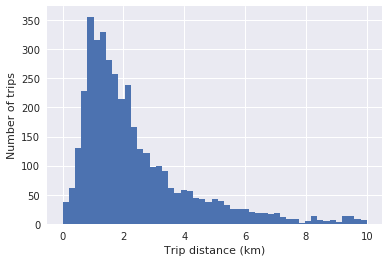

In [27]:
plt.hist(distances[in_lonlat], np.linspace(0., 10., 50))
plt.xlabel('Trip distance (km)')
plt.ylabel('Number of trips')

In [31]:
#NumPy로 밀도 지도 그리기
# 하루중 특정 시간의 승하차 위차에 대한 2D 밀도 지도를 계산하고 그려보자
"""
cf) 판다스는 필터링, 선택, 그룹 등 데이터 조작에 유용. NumPy는 벡터 수학 연산에 탁월
"""
evening = (data.pickup_datetime.dt.hour >= 19).values
n = np.sum(evening)
n #n은 데이터 셋에서 저녁 운행수

242818

In [33]:
"""
n저녁운행헤 대한 모든 승하차 위치 => 2n
승차위치 -1 가중치 부여
하차위치 +1 가중치 부여
주어진 위치의 산술 밀도는 이 위치에서 출발하거나 도착한 사람을 반영
"""
weights = np.zeros(2*n)
weights.shape

(485636,)

In [34]:
weights[:n] = -1
weights[n:] = +1

In [35]:
# 저년 운행에 대한 승하차 위치를 열로 붙인 (2n, 2) 배열 생성
points = np.r_[pickup[evening], dropoff[evening]] # np.r_은 첫번째 열 차원을 따라 배열을 붙이게 된다.
points.shape

(485636, 2)

In [36]:
def lat_lng_to_pixels(lat, lng):
    #메르카토르 도법(Mercator Projection) 좌표=>픽셀
    lat_rad = lat * np.pi / 180.0
    lat_rad = np.log(np.tan((lat_rad + np.pi/2.0)/2.0))
    x=100*(lng+180.0)/360.0
    y=100*(lat_rad-np.pi)/(2.0*np.pi)
    return (x,y)

In [38]:
lon, lat = points.T
x, y = lat_lng_to_pixels(lat, lon)

In [53]:
lon_min, lat_min = -74.0214, 40.6978
lon_max, lat_max = -73.9524, 40.7982

In [54]:
x_min, y_min = lat_lng_to_pixels(lat_min, lon_min)
x_max, y_max = lat_lng_to_pixels(lat_max, lon_max)

In [55]:
binn =.00003 # 히스토그램 구간설정
bins_x = np.arange(x_min, x_max, binn)
bins_y = np.arange(y_min, y_max, binn)

In [57]:
grid, _, _ = np.histogram2d(y, x, weights=weights, bins=(bins_y, bins_x))

In [58]:
# 밀도 함수를 출력하기 전에, 부드럽게 하기위해 로지스틱 함수 적용
density = 1./ (1. +np.exp(-.5 * grid))

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


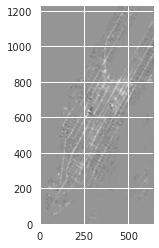

In [59]:
plt.imshow(density, origin='lower', interpolation='bicubic')
# 흰지역은 하차위치, 검은 지역은 승차위치
# 보간interpolation 메소드 지원.
